In [1]:
import numpy as np
import pandas as pd
import scipy.io as scp
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as sts
import xlsxwriter 
import scipy as scy
from PIL import Image
plt.style.use('seaborn-paper')
plt.rc('text',usetex=True)
%matplotlib inline

In [2]:
data = pd.read_excel('Calib_no_silent_one_rep.xlsx',index_col = [0])

In [3]:
data.shape

(40, 657)

In [4]:
from sklearn.model_selection import KFold,train_test_split
from itertools import chain, repeat
from sklearn.metrics import r2_score
from scipy import signal
from scipy.optimize import minimize
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.decomposition import PCA

In [5]:
# HLA does a calibration per substance to be quantified
class HLA(BaseEstimator,RegressorMixin):
    
    def __init__(self,S = None,calibration_concentrations = None,k= None,a = None,concentrations = None,ppal_comp=None):
        
        self.S = S
        self.k = k
        self.a = a
        self.concentrations = concentrations
        self.beta = None
        self.Sb = None
        self.V = None
        self.ppal_comp = None
        self.r = None
    
    def fit(self,S,k,a,ppal_comp):
        self.S = S
        self.k = k
        self.a = a
        self.ppal_comp = ppal_comp
        
        #Remove from S all sepctral contributions from A
        self.Sb = self.S-np.outer(self.k,self.a)
        
        #Generate orthogonal matrix V via PCA
        pca = PCA(n_components=self.ppal_comp)
        pca.fit_transform(self.Sb)
        
        self.V = pca.components_
        
        #Substract from a its projections onto each V vectors
        self.r = self.a-self.a@self.V.T@self.V
        
        #Normalize r to get beta coeffcient vector
        self.beta = self.r/(self.a@self.r)
        
        
    def predict(self,data):
        y = np.zeros(data.shape[0])
        for i in range(data.shape[0]):
            y[i]=self.beta@data[i,:]
        y[y<0]=0
        return y
    
    def score(self,concentrations,calibration_concentrations):
        self.concentrations = concentrations
        self.calibration_concentrations = calibration_concentrations
      
    def RMSE(self):
        assert self.predictions.shape[0] == self.D.shape[0]
        self.RMSE = np.sqrt(mean_squared_error(self.concentrations,self.predictions))
        return self.RMSE
    
    def R2(self):
        assert self.predictions.shape[0] == self.D.shape[0]
        return [r2_score(self.concentrations,self.predictions),\
                r2_score(self.concentrations[:,0],self.predictions[:,0]),\
                r2_score(self.concentrations[:,1],self.predictions[:,1]),\
               r2_score(self.concentrations[:,2],self.predictions[:,2])]

In [6]:
hla = HLA()

In [7]:
X = data.iloc[:,3:]
y = data.iloc[:,:3]

## Try out for the case of DNA 

In [8]:
data

,DNA,Protein,Lipid,602.1677675580994,604.9552030827329,607.7417345407682,610.5273623454752,613.3120869098677,616.0959086467079,618.878827968513,...,3079.377150116299,3081.408413480678,3083.439095551291,3085.46919655781,3087.498716729774,3089.527656296607,3091.556015487615,3093.583794531983,3095.610993658771,3097.637613096928
0,0,135.0,10,0.012688,0.004220,0.008722,0.009507,0.005172,0.008396,0.007709,...,0.007061,0.009683,0.007080,0.008626,0.012706,0.005167,0.003642,0.007328,0.020887,0.024817
1,0,135.0,10,0.009890,0.005801,0.005410,0.006283,0.005336,0.008963,0.008436,...,0.000298,0.004672,0.005236,0.012385,0.026189,0.022183,0.017442,0.014180,0.005175,0.014525
2,0,10.0,10,0.011842,0.012758,0.010111,0.011306,0.011376,0.010408,0.010842,...,0.021909,0.030478,0.028879,0.034934,0.033972,0.037091,0.030974,0.033703,0.046003,0.056378
3,0,50.0,25,0.014653,0.012167,0.001862,0.005409,0.006603,0.008663,0.008482,...,0.011284,0.015806,0.014959,0.016486,0.017686,0.015389,0.014909,0.013764,0.013595,0.030377
4,0,15.0,90,0.050103,0.035198,0.026039,0.031747,0.036573,0.033649,0.025716,...,0.018065,0.022884,0.018201,0.016268,0.034808,0.022003,0.036852,0.031452,0.008917,0.016774
5,0,15.0,90,0.048199,0.052181,0.041842,0.024940,0.028026,0.023787,0.024513,...,0.031576,0.032415,0.050168,0.051174,0.061550,0.018322,0.015634,0.030873,0.013982,0.019021
6,0,60.0,60,0.034693,0.039537,0.015746,0.016896,0.032130,0.025886,0.011782,...,0.034951,0.026196,0.015301,0.017755,0.014631,0.004395,0.019118,0.000902,0.012128,0.019180
7,0,90.0,40,0.008271,0.003980,0.005032,0.006803,0.009474,0.007955,0.004736,...,0.011390,0.012540,0.003959,-0.003130,0.001377,0.006091,0.004885,0.010946,0.017583,0.016289
8,0,10.0,40,0.020873,0.022615,0.023988,0.021095,0.020577,0.024006,0.020952,...,0.011637,0.021533,0.012512,0.017275,0.019713,0.020983,0.034102,0.015320,0.020332,0.025298
9,0,50.0,50,0.010351,0.009146,0.002679,0.007137,0.011463,0.012559,0.014692,...,0.003830,0.004541,0.003379,0.007583,0.006569,0.020515,0.026762,0.027890,0.016546,0.022685


In [9]:
S = data[~data.index.isin([30,31,22,23])].values[:,3:]
S.shape

(36, 654)

In [10]:
k = data[~data.index.isin([30,31,22,23])].iloc[:,0].values
k.shape

(36,)

In [11]:
a = (data.iloc[30,3:]/data.iloc[30,0]).values
a.shape

(654,)

In [12]:
hla.fit(S = S, k = k, a = a, ppal_comp=10)

In [13]:
x = data.iloc[31,:].values[3:]
x = np.vstack((x, data.iloc[22,:].values[3:]))
x = np.vstack((x,data.iloc[23,:].values[3:]))
x.shape

(3, 654)

In [14]:
hla.predict(x)

array([41.20665065,  1.70146606,  0.56857773])

In [15]:
#real value
print(data.iloc[31,:].values[0],data.iloc[22,:].values[0],data.iloc[23,:].values[0])

50.0 0.0 0.0


# Cross validation and optimization # principal components

In [16]:
from sklearn.model_selection import KFold,train_test_split
from itertools import chain, repeat
from sklearn.metrics import r2_score
from scipy import signal
from scipy.optimize import minimize
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sys import stdout
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [17]:
def wave_to_index(shift,minimum_wave,maximum_wave):
    #Enter wavenumber shift and the window limits in cm-1 and returns the index limits of that window
    if type(shift[0])!=int:
        shift = np.floor(shift)
        
    minimum = np.argmax(shift>minimum_wave-1)
    maximum = np.argmax(shift>maximum_wave-1)
    
    return (minimum,maximum)

In [18]:
shift = data.columns.values[3:]
shift[wave_to_index(shift,1799,2701)[0]:wave_to_index(shift,1799,2701)[1]]=np.nan

In [22]:
def optimise_HLA_cv(X, y,a, n_comp,num_folds, plot_components=True):
    '''Run HLA including a variable number of components, up to n_comp,
       and calculate RMSE '''
    RMSE = []
    RMSE_DNA = []
    RMSE_prot = []
    RMSE_lipid = []
    y_cv = np.empty((X.shape[0],3))
    component = np.arange(1, n_comp)
    for i in component:
        hla = HLA()
        # Cross-validation
        
        # Split data into training/test sets
        kf = KFold(n_splits=num_folds, shuffle=True,random_state = 4)
        kf.get_n_splits(X)
        
        for train_index, test_index in kf.split(data):
        #Xval data
            X_train = X[train_index,:]
            X_test = X[test_index,:]
        #One per substance we are demixing
            for j in range(3):
                hla.fit(S = X[train_index,:],k = y[train_index,j],a = a[:,j],ppal_comp = i)
                y_cv[test_index,j]=hla.predict(X[test_index,:])
        
        RMSE_DNA.append(np.sqrt(mean_squared_error(y[:,0], y_cv[:,0])))
        RMSE_prot.append(np.sqrt(mean_squared_error(y[:,1], y_cv[:,1])))
        RMSE_lipid.append(np.sqrt(mean_squared_error(y[:,2], y_cv[:,2])))
        RMSE.append(np.sqrt(mean_squared_error(y, y_cv)))
        comp = 100*(i+1)/n_comp
        # Trick to update status on the same line
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
    # Calculate and print the position of minimum in RMSE
    RMSEmin = np.argmin(RMSE)
    RMSEmin_Lipid = np.argmin(RMSE_lipid)
    print("Suggested number of components overall: ", RMSEmin+1)
    print("Suggested number of components Lipid: ", RMSEmin_Lipid+1)
    stdout.write("\n")
    if plot_components is True:
        fig = plt.figure(figsize=(9,8))
        with plt.style.context(('ggplot')):
            plt.plot(component, np.array(RMSE), '-v', color = 'blue', mfc='blue')
            plt.plot(component[RMSEmin], np.array(RMSE)[RMSEmin], 'P', ms=20, mfc='red')
            plt.xlabel('$\mathrm{Number\: of\: HLA\: components}$',fontsize=30)
            plt.ylabel('$\mathrm{RMSE}$',fontsize=30)
            plt.title('$\mathrm{HLA}$',fontsize=30)
            plt.xlim(left=-1)
            plt.tick_params(labelsize=25)
        plt.show()
        with plt.style.context(('ggplot')):
            plt.plot(component, np.array(RMSE_lipid), '-v', color = 'blue', mfc='blue')
            plt.plot(component[RMSEmin_Lipid], np.array(RMSE_lipid)[RMSEmin_Lipid], 'P', ms=10, mfc='red')
            plt.xlabel('$\mathrm{Number\: of\: HLA\: components}$')
            plt.ylabel('$\mathrm{RMSE_{Lipid}}$')
            plt.title('$\mathrm{HLA_{Lipid}}$')
            plt.xlim(left=-1)
        plt.show()
        fig.savefig('HLAi.jpeg',dpi=300)
    # Define HLA object with optimal number of components
    HLA_opt = HLA()
    # Fit to the entire dataset 
    y_cv = np.empty((X.shape[0],3))
    y_c = np.empty((X.shape[0],3))
    for j in range(3):
        hla.fit(S = X,k = y[:,j],a = a[:,j],ppal_comp = RMSEmin+1)
        y_c[train_index,j]=hla.predict(X[train_index,:])
        
    
    # Cross-validation
    
    # Split data into training/test sets
    kf = KFold(n_splits=num_folds, shuffle=True,random_state = 1)
    kf.get_n_splits(X)
        
    for train_index, test_index in kf.split(data):
        #Xval data
        X_train = X[train_index,:]
        X_test = X[test_index,:]
        #One per substance we are demixing
        for j in range(3):
            hla.fit(S = X_train,k = y[train_index,j],a = a[:,j],ppal_comp = RMSEmin+1)
            y_cv[test_index,j]=hla.predict(X[test_index,:])
    
    #Set negatives to zero
    y_c[y_c < 0]= 0
    y_cv[y_cv < 0] = 0
    
    # Calculate scores for calibration and cross-validation
    R2_cv = r2_score(y,y_cv)
    RMSE = np.sqrt(mean_squared_error(y, y_cv))
    
    R2_c_DNA = r2_score(y[:,0], y_c[:,0])
    R2_cv_DNA = r2_score(y[:,0], y_cv[:,0])
    R2_c_prot = r2_score(y[:,1], y_c[:,1])
    R2_cv_prot = r2_score(y[:,1], y_cv[:,1])
    R2_c_lipid = r2_score(y[:,2], y_c[:,2])
    R2_cv_lipid = r2_score(y[:,2], y_cv[:,2])
    # Calculate mean squared error for calibration and cross validation
    RMSE_c_DNA = np.sqrt(mean_squared_error(y[:,0], y_c[:,0]))
    RMSE_cv_DNA = np.sqrt(mean_squared_error(y[:,0], y_cv[:,0]))
    RMSE_c_prot = np.sqrt(mean_squared_error(y[:,1], y_c[:,1]))
    RMSE_cv_prot = np.sqrt(mean_squared_error(y[:,1], y_cv[:,1]))
    RMSE_c_lipid = np.sqrt(mean_squared_error(y[:,2], y_c[:,2]))
    RMSE_cv_lipid = np.sqrt(mean_squared_error(y[:,2], y_cv[:,2]))
    print('\nDNA:')
    print('R2 calib: %5.3f'  % R2_c_DNA)
    print('R2 CV: %5.3f'  %R2_cv_DNA)
    print('RMSE calib: %5.3f' % RMSE_c_DNA)
    print('RMSE CV: %5.3f' % RMSE_cv_DNA)
    print('\nProtein:')
    print('R2 calib: %5.3f'  % R2_c_prot)
    print('R2 CV: %5.3f'  %R2_cv_prot)
    print('RMSE calib: %5.3f' % RMSE_c_prot)
    print('RMSE CV: %5.3f' % RMSE_cv_prot)
    print('\nLipid:')
    print('R2 calib: %5.3f'  % R2_c_lipid)
    print('R2 CV: %5.3f'  %R2_cv_lipid)
    print('RMSE calib: %5.3f' % RMSE_c_lipid)
    print('RMSE CV: %5.3f' % RMSE_cv_lipid)

    # Fit a line to the CV vs response
    #z = np.polyfit(y, y_c, 1)
    with plt.style.context(('ggplot')):

        fig, ax = plt.subplots(nrows = 1,ncols = 3,figsize=(25,7.5))
#         ax.scatter(y_c, y, c='red', edgecolors='k')
        ax = ax.ravel()
        ax [0].scatter(y[:,0],y_cv[:,0], color='green',label = 'DNA',s=80)
        ax[1].scatter(y[:,1],y_cv[:,1],  color='orange',label = 'Protein',s=80)
        ax[2].scatter(y[:,2],y_cv[:,2],  color='blue',label = 'Lipid',s=80)
        #Plot the best fit line
        #ax.plot(np.polyval(z,y), y, c='black', linewidth=1)
        #Plot the ideal 1:1 line
        ax[0].plot(y[:,0], y[:,0], color='black', linewidth=1,alpha = .5)
        ax[1].plot(y[:,1], y[:,1], color='black', linewidth=1,alpha = .5)
        ax[2].plot(y[:,2], y[:,2], color='black', linewidth=1,alpha = .5)
        
        ax[0].tick_params(labelsize=25)
        ax[1].tick_params(labelsize=25)
        ax[2].tick_params(labelsize=25)

        
        
        plt.suptitle('$R^{2}_ {CV}: '+str(R2_cv)+', \: RMSE_{CV}:'+np.str(RMSE)+'$',fontsize = 20,y=1.1)
        # add a big axis, hide frame
        ax2=fig.add_subplot(111, frameon=False,)
        ax2.grid(None)
        # hide tick and tick label of the big axis
        plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
        plt.xlabel('$\mathrm{Ground \:truth\: (mg/mL)}$',fontsize = 70,labelpad=35)
        plt.ylabel('$\mathrm{Predicted}$',fontsize = 70,labelpad=35)
        plt.tight_layout()
        plt.show()
        fig.savefig('HLAii.jpeg',dpi=300)
    return

In [23]:
a_DNA = (data.iloc[30,3:]/data.iloc[30,0]).values
a_Prot = (data.iloc[19,3:]/data.iloc[19,1]).values
a_Lipid = (data.iloc[25,3:]/data.iloc[25,2]).values
#stack them in one matrix
a = np.vstack((a_DNA,a_Prot,a_Lipid)).T
a.shape

(654, 3)

In [24]:
X = data.iloc[:,3:].values
y = data.iloc[:,:3].values

Maximum number of components we can use 25
100% completed
Suggested number of components overall:  6
Suggested number of components Lipid:  6



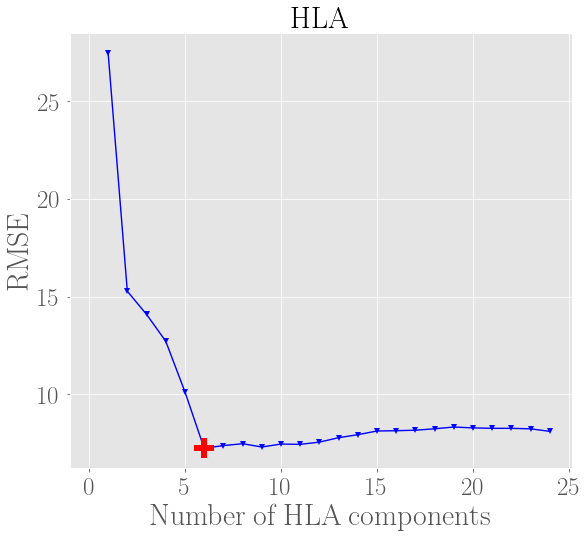

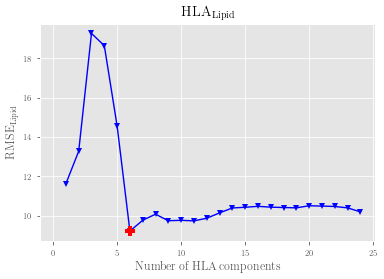


DNA:
R2 calib: 0.962
R2 CV: 0.932
RMSE calib: 3.269
RMSE CV: 4.395

Protein:
R2 calib: 0.992
R2 CV: 0.988
RMSE calib: 5.953
RMSE CV: 7.188

Lipid:
R2 calib: 0.950
R2 CV: 0.885
RMSE calib: 6.039
RMSE CV: 9.198


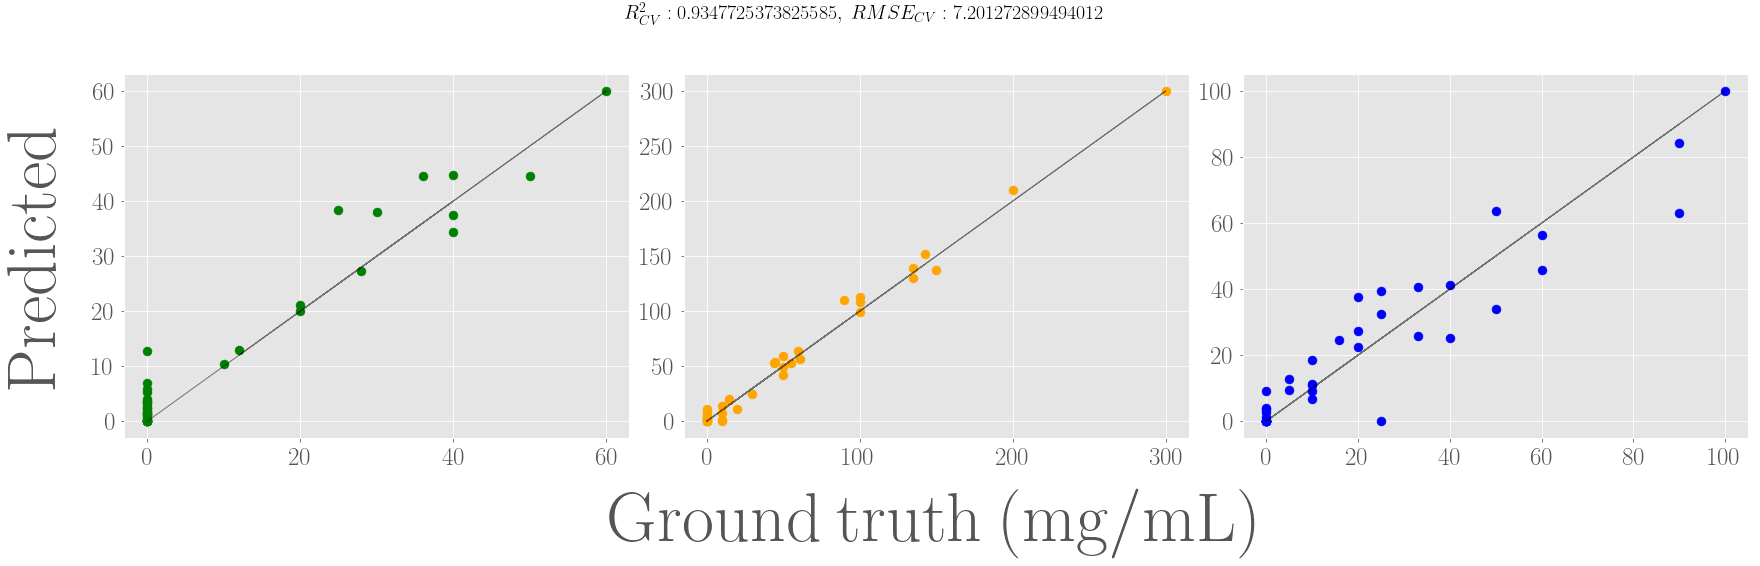

In [25]:
num_folds = 10 #CV folds (k)
n_comp = int(np.min(abs(np.min(X.shape)-(np.floor(np.array(X.shape)/num_folds)))))
print('Maximum number of components we can use',n_comp)
optimise_HLA_cv(X=X,y=y,a=a,n_comp=n_comp,num_folds=num_folds)